当前在线广告服务中，广告的点击率（CTR）是评估广告效果的一个非常重要的指标。 因此，点击率预测系统是必不可少的，并广泛用于赞助搜索和实时出价。那么如何计算广告的点击率呢？

### 广告的点击率 = 广告点击量/广告的展现量

如果一个广告被展现了100次，其中被点击了20次，那么点击率就是20%。

今天我们就来动手开发一个移动广告点击率的预测系统，我们数据来自于kaggle，数据包含了10天的Avazu的广告点击数据。

# 数据

你可以在这里<a href="https://www.kaggle.com/c/avazu-ctr-prediction/data">下载</a>移动广告点击数据,由于总数据量达到了4千多万条，数据量过于庞大,为了不影响我们的计算速度,因此我们要从中随机抽样100万条数据，同时我们要对数据的相关字段类型进行重置,这有助于我们以后的计算以及可视化。

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import gzip
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
%matplotlib inline

In [2]:
types_train = {
    'id': np.dtype(int), 
    'click': np.dtype(int),       #是否点击,1表示被点击,0表示没被点击
    'hour': np.dtype(int),        #广告被展现的日期+时间
    'C1': np.dtype(int),          #匿名分类变量
    'banner_pos': np.dtype(int),  #广告位置
    'site_id': np.dtype(str),     #站点Id
    'site_domain': np.dtype(str),  #站点域名
    'site_category': np.dtype(str), #站点分类
    'app_id': np.dtype(str),        # appId 
    'app_domain': np.dtype(str),    # app域名
    'app_category': np.dtype(str),  # app分类
    'device_id': np.dtype(str),     #设备Id
    'device_ip': np.dtype(str),     #设备Ip
    'device_model': np.dtype(str),  #设备型号
    'device_type': np.dtype(int),   #设备型号
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),   #匿名分类变量
    'C15': np.dtype(int),   #匿名分类变量
    'C16': np.dtype(int),   #匿名分类变量
    'C17': np.dtype(int),   #匿名分类变量
    'C18': np.dtype(int),   #匿名分类变量
    'C19': np.dtype(int),   #匿名分类变量
    'C20': np.dtype(int),   #匿名分类变量
    'C21':np.dtype(int)    #匿名分类变量
}


In [3]:
n = 40428967  #数据集中的记录总数
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

with gzip.open('./data/ctr/train.gz') as f:
    train = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, dtype=types_train, skiprows = skip_values)
print(len(train))
train.head()

1000000


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,-1636923355,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2a1ca37,2347f47a,...,1,0,15708,320,50,1722,0,35,-1,79
1,-193497663,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,17747,320,50,1974,2,39,100021,33
2,1315205890,0,2014-10-21,1002,0,85f751fd,c4e18dd6,50e219e0,a37bf1e4,7801e8d9,...,0,0,21691,320,50,2495,2,167,-1,23
3,1336077603,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,-1,79
4,-1368186722,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15708,320,50,1722,0,35,100084,79


# 特征工程

接下来我们要做的就是数据的探索性分析(EDA)和特征工程(Feature Engineering),首先我们要确定哪些目标变量，哪些是特征变量,根据kaggle中对数据的描述信息中我们可知,目标变量就是"click"字段它表示广告是否被点击过(1表示被点击,0未被点击)，其余所有的字段都是特征变量。在特征变量中C1,C14~C21表示匿名的分类变量(我们不知道它的含义)，其余的特征变量都是和站点,app,设备相关的变量。我们搞清了变量的大概含义以后,接下来我们要分析一下目标变量"click"，首先看看它的数据分布情况:

0    830365
1    169635
Name: click, dtype: int64

0    0.830365
1    0.169635
Name: click, dtype: float64


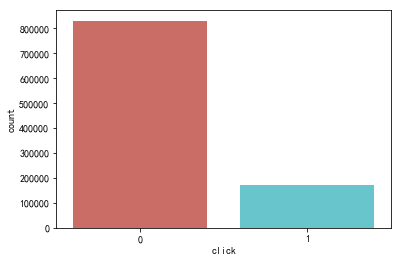

In [4]:
print(train['click'].value_counts())
print()
print(train['click'].value_counts()/len(train))
# train['click'].value_counts().plot(label='dd',kind = 'bar')
sns.countplot(x='click',data=train, palette='hls')
plt.show()

在“click”变量的统计数据中，点击的数量大约占17%，未点击的数量大约占83%。也就是说广告的平均点击率大概是在17%左右。

接下来我们来分析另外一个关键的特征变量:hour,它可能表示广告被展现的日期+时间，我们要看看不同的日期和时间对广告点击量的影响:

In [5]:
train.hour.describe()

count                 1000000
unique                    240
top       2014-10-22 09:00:00
freq                    11357
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

count                 1000000
unique                    240
top       2014-10-22 09:00:00
freq                    11357
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object


Text(0.5, 1.0, '时间和点击量')

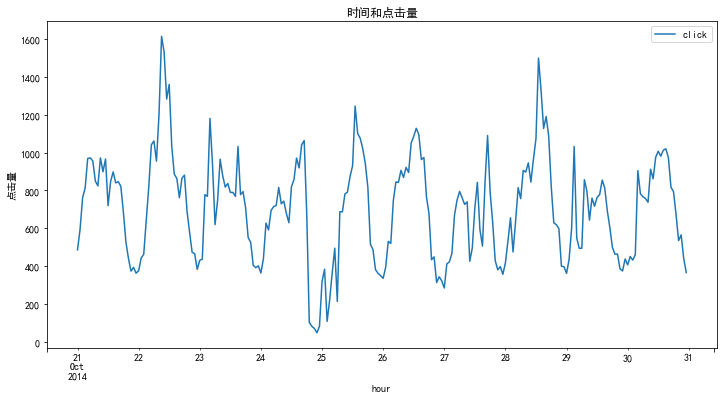

In [6]:
print(train.hour.describe())

train.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('点击量')
plt.title('时间和点击量')

由上面的统计结果可知数据的开始时间是2014-10-21 00:00:00,结束时间是2014-10-30 23:00:00，一共10天，点击量高峰的时刻是在10月22日和10月28日这两天，10月24日点击量最低。

## 对Hour的特征工程
我们知道hour变量包含了具体的日期和时间,接下来我们想知道点击量和具体的时间是什么关系,此时我们忽略日期,只关注具体时间和点击量。接下来我们从hour变量中抽取时间,然后查看时间和点击量之间的关系:

In [7]:
train['time'] = train.hour.apply(lambda x: x.hour)
train.sample(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,time
940121,49763770,0,2014-10-30 10:00:00,1005,0,a82179f8,62b6befe,3e814130,ecad2386,7801e8d9,...,0,23908,320,50,2741,0,163,-1,17,10
479783,-1721082668,0,2014-10-25 18:00:00,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,0,19771,320,50,2227,0,679,-1,48,18
838574,1186530652,0,2014-10-29 09:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,23161,320,50,2667,0,35,100148,221,9
344962,-2065125200,1,2014-10-24 04:00:00,1002,0,887a4754,e3d9ca35,50e219e0,ecad2386,7801e8d9,...,0,6563,320,50,572,2,39,-1,32,4
936566,1805891415,0,2014-10-30 09:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,685d1c4c,2347f47a,...,2,23224,320,50,2676,0,299,100176,221,9


Text(0.5, 1.0, '时间和点击量')

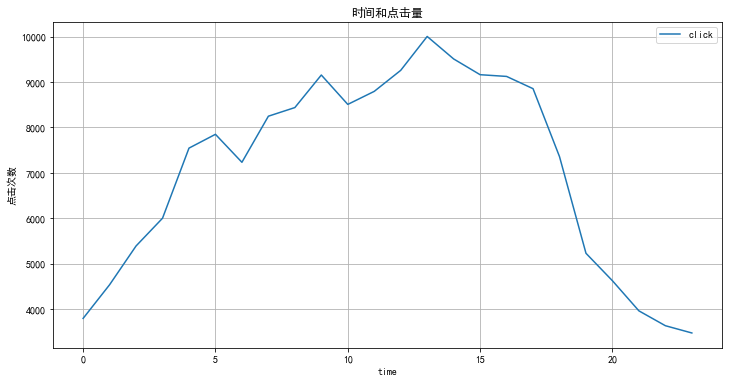

In [8]:
train.groupby('time').agg({'click':'sum'}).plot(figsize=(12,6),grid=True)
plt.ylabel('点击次数')
plt.title('时间和点击量')

我们看到点击量的高峰大约是在每天下午的13点到14点之间 ,点击量的最低点是在每天的零点左右。这应该是合理的，因为下午1点到2点应该是人们精力最旺盛的时候，而晚上零点大部分人都进入了梦乡。

接下来我们要查看一下在不同的时间点的情况下，广告的展现量和点击量的关系:

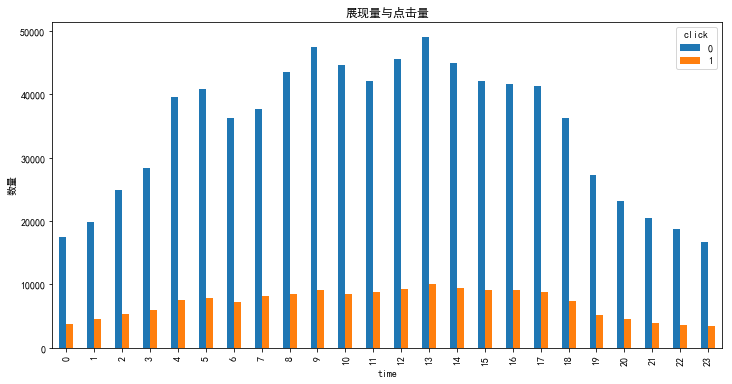

In [9]:
train.groupby(['time', 'click']).size().unstack().plot(kind='bar', figsize=(12,6))
plt.ylabel('数量')
plt.title('展现量与点击量');

我们将时间按每个时间点展开,这里没有特别之处下午1点的展现量最大,所以点击量也是最大,我们发现展现量和点击量似乎是成正比的。这似乎也告诉我们，如果您要投放在线广告，请在下午1点至2点之间投放,因为此时广告的展现量和点击量都是最大的。

接下来我们来计算一下各个时间点的广告点击率，并查看点击率的数据分布。

In [10]:
df_click = train[train['click'] == 1]
df_hour = train[['time','click']].groupby(['time']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['time','click']].groupby(['time']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100
df_hour.head()

,time,impressions,clicks,CTR
0,0,21234,3793,17.862861
1,1,24463,4534,18.534113
2,2,30313,5388,17.774552
3,3,34386,5999,17.446054
4,4,47211,7543,15.977209


Text(0.5, 1.0, '点击率的时间分布')

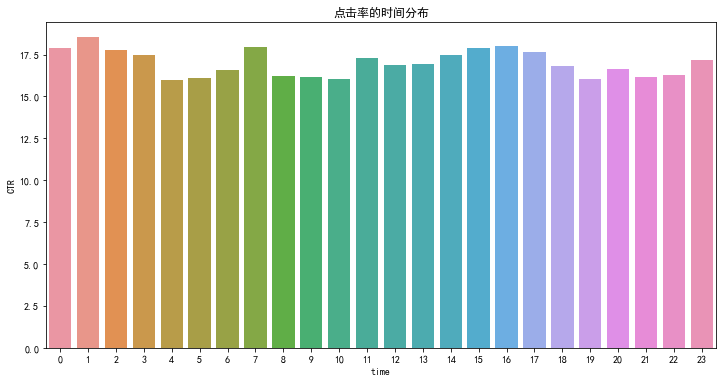

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='time', data=df_hour)
plt.title('点击率的时间分布')

在这里我们发现了一件有趣的事，广告点击率最高的时间点居然在凌晨1点，上午7点，下午16点，而从之前的分析中我知道广告展现量最高的时间点是在下午的13点， 但是从上图中我们可知13点的广告点击率并非是最高的。这似乎说明高的展现量和高的点击量并不意味着就有高的点击率。凌晨1点上网的“夜游神”们才是点击率的真正贡献者。

## 按星期特征工程

前面我们我们已经分别实现了按日期和按时间两种方式来分析点击率,接下来我们再继续扩展对hour变量的分析,这回我们要按星期来分析点击率。我们首先要把hour变量转换成星期。

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '星期的点击量')

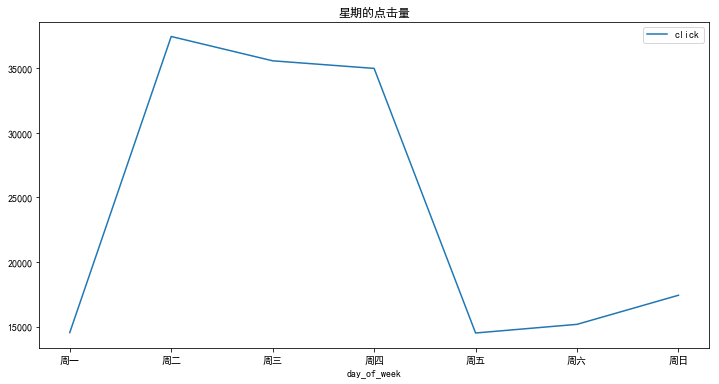

In [12]:
train['day_of_week'] = train['hour'].apply(lambda val: val.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train.groupby('day_of_week').agg({'click':'sum'}).reindex(cats).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) 
labels = "周一 周二 周三 周四 周五 周六 周日".split()
plt.xticks(ticks, labels)
plt.title('星期的点击量')

Text(0.5, 1.0, '星期的展现量和点击量分布')

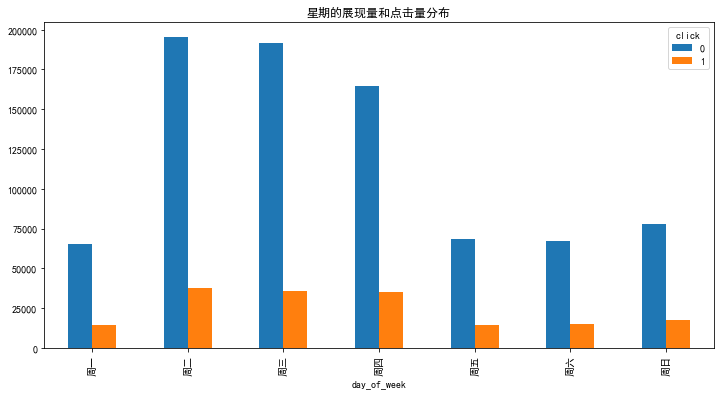

In [13]:

train.groupby(['day_of_week','click']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) 
labels = "周一 周二 周三 周四 周五 周六 周日".split()
plt.xticks(ticks, labels)
plt.title('星期的展现量和点击量分布')

从上图可知星期二的展现量和点击量是最高的，接下来是星期三和星期四，不过展现量和点击量较高并不意味着点击率也较高，因此接下来我们要按星期来计算一下点击率。

Text(0.5, 1.0, '星期的点击率')

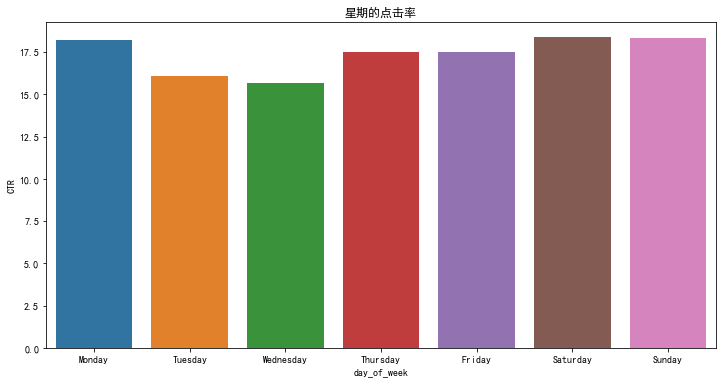

In [14]:

df_click = train[train['click'] == 1]
df_dayofweek = train[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['impressions']*100

plt.figure(figsize=(12,6))
# sns.set(style="whitegrid")
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('星期的点击率')

通过之前的我们知道星期二和星期三有着最高的展现量和点击量，可是他们的点击率却是最低的。相反星期六和星期天却有着最高的点击率。这是否说明星期六和星期天是人民群众最空闲的时候，有了空闲时间大家才会想到去购物，所以广告的点击率才会是最高的？

通过对数据的严谨分析，我们就会从中发现人民群众的日常行为举止以及他们的活动规律都会在数据中得到体现，只要你足够努力，就可以让数据说话！

## 匿名特征变量C1

C1是一个匿名的分类型变量，我们不知道它的含义，我们先查看一下c1的数据分布

In [15]:
print(train.C1.value_counts()/len(train))

1005    0.918282
1002    0.055076
1010    0.022543
1012    0.002868
1007    0.000855
1001    0.000239
1008    0.000137
Name: C1, dtype: float64


因为C1是分类型变量，它的值包含了1005,1002,1010,1012,1007,1001,1008七种，其中1005的所占比例高达91.87%，接下来我们看看C1的不同的值对点击率的贡献

In [16]:
C1_values = train.C1.unique()
C1_values.sort()
ctr_avg_list=[]
for i in C1_values:
    ctr_avg=train.loc[np.where((train.C1 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print(" C1 value: {},  点击率: {}".format(i,ctr_avg))

 C1 value: 1001,  点击率: 0.03347280334728033
 C1 value: 1002,  点击率: 0.21112644345994624
 C1 value: 1005,  点击率: 0.16909838154292473
 C1 value: 1007,  点击率: 0.03976608187134503
 C1 value: 1008,  点击率: 0.1386861313868613
 C1 value: 1010,  点击率: 0.09754691034911059
 C1 value: 1012,  点击率: 0.16283124128312412


从上面的统计结果可知,虽然1005数据量所占比重最高,但是它的点击率并不是最高,1002的点击率最高达到了21.3%。接下来我们看一下C1的展现量和点击量的分布

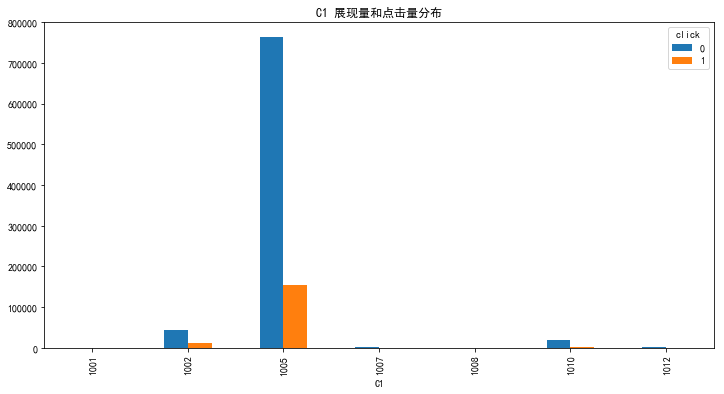

In [17]:
train.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 展现量和点击量分布');

从上图可知，1005的展现量和点击量是最高的，但这并不意味着点击率也是最高的，下面我们看一下C1的点击率的分布

Text(0.5, 1.0, 'C1的点击率分布')

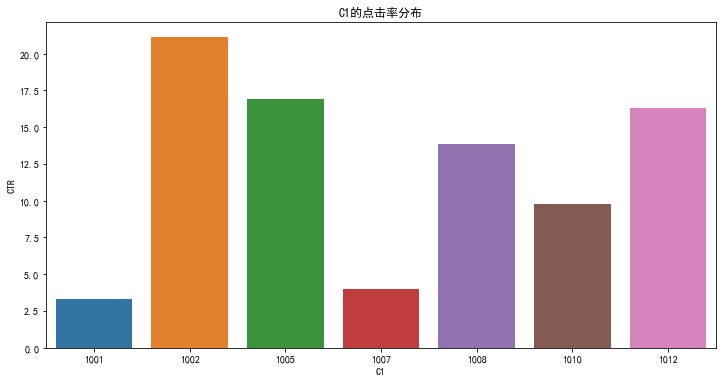

In [18]:
df_c1 = train[['C1','click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1','click']].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('C1的点击率分布')

我们看到点击率最高的并不是1005，而是1002. 它的点击率达到了21%，下面我们总结一下C1数据量和点击率的分布:

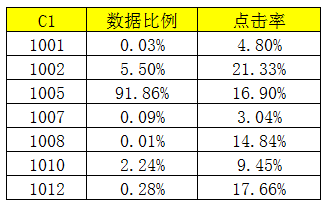

从上表中我们可以看出,1002的数据比例是5.5%，它贡献的点击率为21.33%远大于17%的平均点击率，1002的数据比例为0.28%却贡献了17.66%的点击率，1008的数据比例是0.01%，它贡献了14.84%的点击率，性价比非常高。

## banner_pos
banner_pos表示广告在网页中的位置，广告摆放在网页的不同位置可能会带来不同的点击量和点击量，下面我们就来分析一下banner_pos这个分类型变量。首先我们查看一下banner_pos的数据分布

In [19]:
print(train.banner_pos.value_counts()/len(train))

0    0.719386
1    0.278839
7    0.001117
2    0.000309
4    0.000162
5    0.000137
3    0.000050
Name: banner_pos, dtype: float64


从上面的统计结果可知banner_pos包含了7个值,它可能代表网页中的7个不同位置，其中位置0和位置1占据了机会99%的数据比例，也就是说绝大多数广告都房子了位置0或者位置1的地方。

下面我们看看不同位置对点击率的贡献:

In [20]:
banner_pos = train.banner_pos.unique()
banner_pos.sort()
ctr_avg_list=[]
for i in banner_pos:
    ctr_avg=train.loc[np.where((train.banner_pos == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print(" banner 位置: {},  点击率: {}".format(i,ctr_avg))

 banner 位置: 0,  点击率: 0.164067691058764
 banner 位置: 1,  点击率: 0.18354677788975
 banner 位置: 2,  点击率: 0.12297734627831715
 banner 位置: 3,  点击率: 0.16
 banner 位置: 4,  点击率: 0.1419753086419753
 banner 位置: 5,  点击率: 0.1386861313868613
 banner 位置: 7,  点击率: 0.3034914950760967


位置0和位置1的点击率分别为16.4%和18.2%，它们的点击率并不是最高。位置7和位置3的点击率分别达到了33%和24%，它们的点击率要比位置1和位置0高很多。

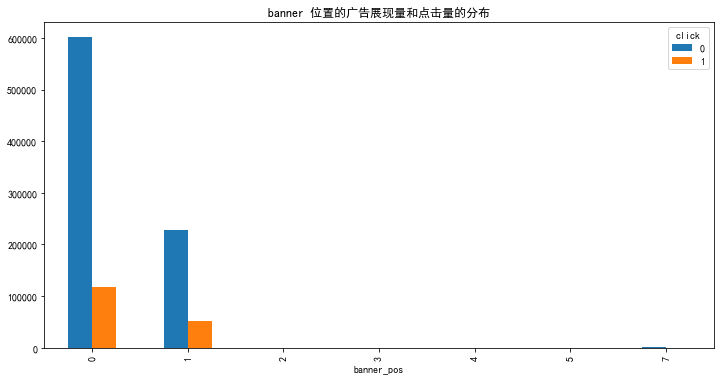

In [21]:
train.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='banner 位置的广告展现量和点击量的分布')

下面我们再看一下banner_pos的点击率的分布

Text(0.5, 1.0, 'banner 位置的点击率的分布')

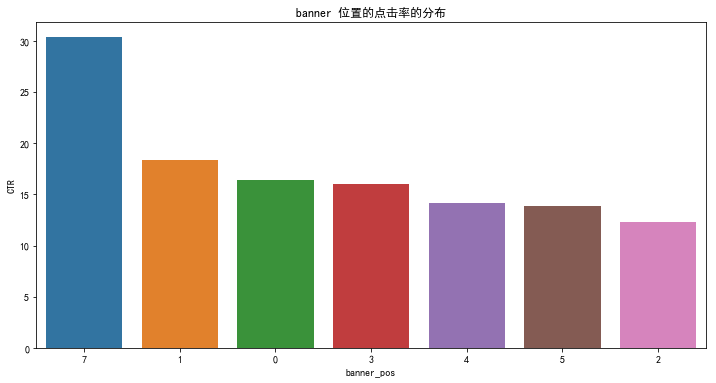

In [22]:
df_banner = train[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks']/df_banner['impressions']*100
sort_banners = df_banner.sort_values(by='CTR',ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners)
plt.title('banner 位置的点击率的分布')

从上图可知位置7和位置3的点击率是最高的，但是他们的数据比例并不是最高的，相反位置0和位置1的数据比例，展现量和点击量都是最高的，但是他们的点击率并非最高。

## device_type

device_type表示设备类型，广告可能会在多种设备上展示，下面我们看一下device_type的数据分布

In [23]:
print((train.device_type.value_counts()/len(train)))

1    0.922380
0    0.055076
4    0.019286
5    0.003257
2    0.000001
Name: device_type, dtype: float64


我们看到一共有4种设备，其中设备1所占比例最大达到了92%， 绝大多数广告都是在设备1上展示的。下面我们看一下展现量和点击量的分布

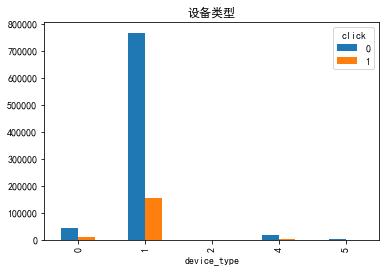

In [24]:
train[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar', title='设备类型')

我们看到设备1上的广告展现量和点击量都是最大的。其他设备的展现量和点击量相对较少。为此我们要详细分析一下设备1上的点击量的情况，我们按照不同的时间点对设备1的点击量进行一下分析。

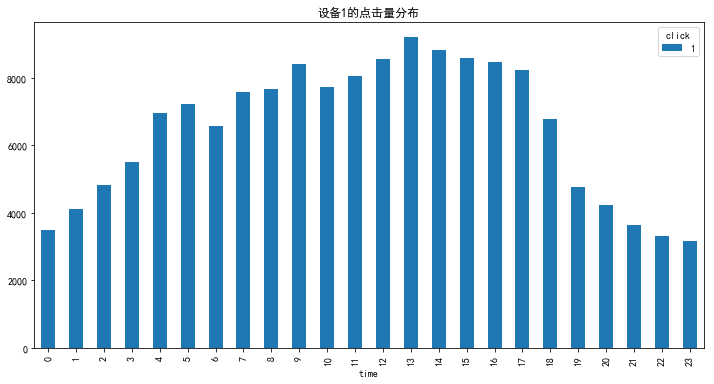

In [25]:
df_click[df_click['device_type']==1].groupby(['time', 'click'])\
                                     .size().unstack()\
                                     .plot(kind='bar', title="设备1的点击量分布", figsize=(12,6))

从上图可知，设备1上的点击量最高点位于下午1点，这和我们之前按时间分析点击量的结果是一致的。

下面我们分别统计出所有类型的设备的点击量、展现量和点击率。

In [26]:
device_type_click = df_click.groupby('device_type').agg({'click':'sum'}).reset_index()
device_type_impression = train.groupby('device_type').agg({'click':'count'}).reset_index().rename(columns={'click': 'impressions'})
merged_device_type = pd.merge(left = device_type_click , right = device_type_impression, how = 'inner', on = 'device_type')

merged_device_type['CTR'] = merged_device_type['click'] / merged_device_type['impressions']*100

merged_device_type

,device_type,click,impressions,CTR
0,0,11628,55076,21.112644
1,1,155808,922380,16.891953
2,4,1878,19286,9.737634
3,5,321,3257,9.855695


我们看到点击率最高的设备是设备0，并不是设备1.所以说展现量和点击量都较高并不意味着点击率也会较高。

### app features

In [27]:
print("app_id的唯一值有 {} 个".format(train.app_id.nunique()))
print("app_domain的唯一值有 {} 个".format(train.app_domain.nunique()))
print("app_category的唯一值有 {} 个".format(train.app_category.nunique()))

app_id的唯一值有 3122 个
app_domain的唯一值有 197 个
app_category的唯一值有 26 个


In [28]:
print((train.app_category.value_counts()/len(train)))

07d7df22    0.647846
0f2161f8    0.236653
cef3e649    0.042757
8ded1f7a    0.035973
f95efa07    0.027883
d1327cf5    0.003055
dc97ec06    0.001336
09481d60    0.001328
75d80bbe    0.000947
fc6fa53d    0.000564
4ce2e9fc    0.000519
879c24eb    0.000325
a3c42688    0.000291
4681bb9d    0.000171
0f9a328c    0.000133
2281a340    0.000059
a86a3e89    0.000057
8df2e842    0.000048
79f0b860    0.000019
0bfbc358    0.000010
a7fd01ec    0.000008
7113d72a    0.000006
18b1e0be    0.000005
5326cf99    0.000003
2fc4f2aa    0.000003
bd41f328    0.000001
Name: app_category, dtype: float64


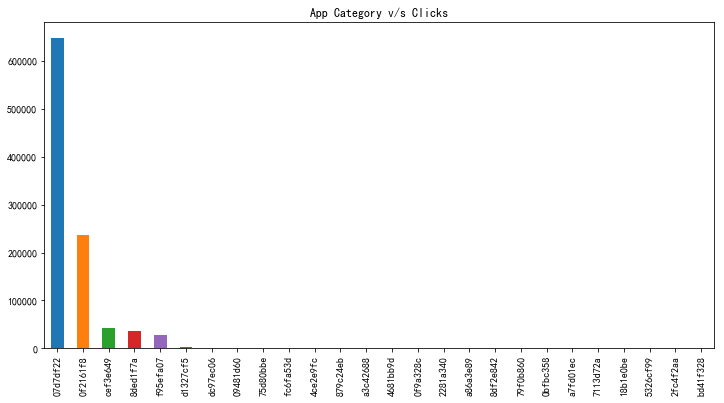

In [29]:
train['app_category'].value_counts().plot(kind='bar', title='App Category v/s Clicks',figsize=(12,6))

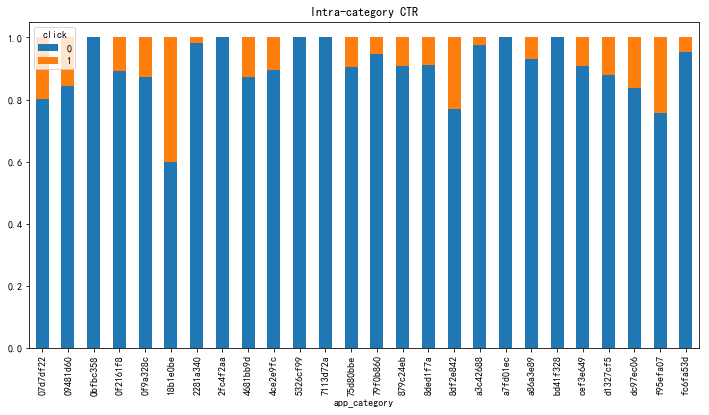

In [30]:
train_app_category = train.groupby(['app_category', 'click']).size().unstack()
train_app_category.div(train_app_category.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR",figsize=(12,6))

### C14 - C21 features

In [31]:
print("C14的唯一值有 {} 个".format(train.C14.nunique()))
print("C15的唯一值有 {} 个".format(train.C15.nunique()))
print("C16的唯一值有 {} 个".format(train.C16.nunique()))
print("C17的唯一值有 {} 个".format(train.C17.nunique()))
print("C18的唯一值有 {} 个".format(train.C18.nunique()))
print("C19的唯一值有 {} 个".format(train.C19.nunique()))
print("C20的唯一值有 {} 个".format(train.C20.nunique()))

C14的唯一值有 2253 个
C15的唯一值有 8 个
C16的唯一值有 9 个
C17的唯一值有 421 个
C18的唯一值有 4 个
C19的唯一值有 66 个
C20的唯一值有 165 个


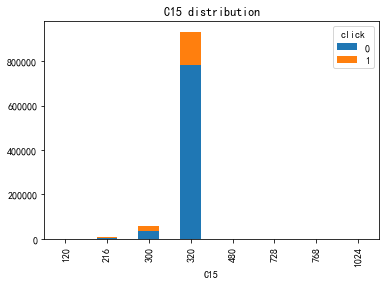

In [32]:
train.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C15 distribution')

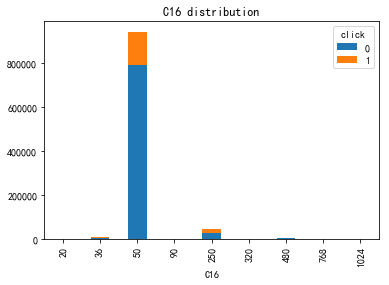

In [33]:
train.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C16 distribution')

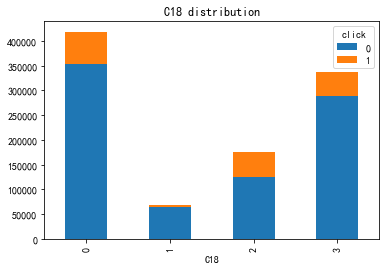

In [34]:
train.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 distribution')

# 建模

## has简介
由于我们的的数据样本量有100万条，特征变量有20个左右，那么总共的特征值将会有100万X20=2000万个左右，为了减少系统内存的消耗，我们要使用python的内置hash函数来映射某些特征变量，我们要将那些类型为object的特征变量映射为一定范围内的整数(原来的string被映射成了integer)，这样就可以大大降低内存的消耗。
下面我们看看未使用hash之前我们的样本数据:

In [35]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,time,day_of_week
0,-1636923355,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2a1ca37,2347f47a,...,15708,320,50,1722,0,35,-1,79,0,Tuesday
1,-193497663,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,17747,320,50,1974,2,39,100021,33,0,Tuesday
2,1315205890,0,2014-10-21,1002,0,85f751fd,c4e18dd6,50e219e0,a37bf1e4,7801e8d9,...,21691,320,50,2495,2,167,-1,23,0,Tuesday
3,1336077603,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15701,320,50,1722,0,35,-1,79,0,Tuesday
4,-1368186722,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15708,320,50,1722,0,35,100084,79,0,Tuesday


下面我们要将hash函数将类型为object的变量映射成integer型

In [36]:
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
train = convert_obj_to_int(train)
train.head()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,...,site_id_int,site_domain_int,site_category_int,app_id_int,app_domain_int,app_category_int,device_id_int,device_ip_int,device_model_int,day_of_week_int
0,-1636923355,0,2014-10-21,1005,0,1,0,15708,320,50,...,3294295106353209792,-7871480762403810028,-1726633989484689459,3967604608139905137,-387442148922046908,3587892912659238008,-6860200936241454220,-7863861599293986987,8122318252297648011,-6056180354402690469
1,-193497663,0,2014-10-21,1005,1,1,0,17747,320,50,...,-1088018682312011499,-8030684975096413899,-7766034975137587207,-5153835905196929001,9059885572487474882,5089309385467275041,5788537550175848951,588395654717179763,7072708345363904469,-6056180354402690469
2,1315205890,0,2014-10-21,1002,0,0,0,21691,320,50,...,3294295106353209792,-7871480762403810028,-1726633989484689459,5064714988463203132,9059885572487474882,5089309385467275041,-8229604351924704167,8009012252837729359,-6538374976293708962,-6056180354402690469
3,1336077603,0,2014-10-21,1005,0,1,0,15701,320,50,...,4322696643391637070,-3123241050271775153,7354276305300575896,-5153835905196929001,9059885572487474882,5089309385467275041,5788537550175848951,-5845137796421209069,-3805608367665034636,-6056180354402690469
4,-1368186722,1,2014-10-21,1005,0,1,0,15708,320,50,...,4322696643391637070,-3123241050271775153,7354276305300575896,-5153835905196929001,9059885572487474882,5089309385467275041,5788537550175848951,8085682286269281170,7088212619388353806,-6056180354402690469


## LightGBM 模型 

<a href="https://lightgbm.readthedocs.io/en/latest/">LightGBM</a>是个快速的，分布式的，高性能的基于决策树算法的梯度提升框架。可用于排序，分类，回归以及很多其他的机器学习任务中,接下来我们要使用LightGBM作为我们的分类模型.

In [37]:
train.drop('hour', axis=1, inplace=True)
train.drop('id', axis=1, inplace=True)

In [38]:
X_train = train.loc[:, train.columns != 'click']
y_target = train.click.values

msk = np.random.rand(len(X_train)) < 0.8
lgb_train = lgb.Dataset(X_train[msk], y_target[msk])
lgb_eval = lgb.Dataset(X_train[~msk], y_target[~msk], reference=lgb_train)

In [39]:

# 配置模型参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31, # 每棵树的默认叶子数
    'learning_rate': 0.08,
    'feature_fraction': 0.7, # 将在训练每棵树之前选择70％的特征
    'bagging_fraction': 0.3, #随机选择30%的特征。
    'bagging_freq': 5, #  每5次迭代执行bagging
    'verbose': 0
}

print('开始训练...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

开始训练...
[1]	valid_0's binary_logloss: 0.448408
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.444125
[3]	valid_0's binary_logloss: 0.440432
[4]	valid_0's binary_logloss: 0.437069
[5]	valid_0's binary_logloss: 0.434273
[6]	valid_0's binary_logloss: 0.431874
[7]	valid_0's binary_logloss: 0.429536
[8]	valid_0's binary_logloss: 0.427666
[9]	valid_0's binary_logloss: 0.426059
[10]	valid_0's binary_logloss: 0.424549
[11]	valid_0's binary_logloss: 0.423223
[12]	valid_0's binary_logloss: 0.422081
[13]	valid_0's binary_logloss: 0.420984
[14]	valid_0's binary_logloss: 0.420014
[15]	valid_0's binary_logloss: 0.419035
[16]	valid_0's binary_logloss: 0.418202
[17]	valid_0's binary_logloss: 0.417401
[18]	valid_0's binary_logloss: 0.416707
[19]	valid_0's binary_logloss: 0.416105
[20]	valid_0's binary_logloss: 0.415556
[21]	valid_0's binary_logloss: 0.414978
[22]	valid_0's binary_logloss: 0.414532
[23]	valid_0's binary_logloss: 0.414154
[24]	valid_0's bin

[211]	valid_0's binary_logloss: 0.401444
[212]	valid_0's binary_logloss: 0.401421
[213]	valid_0's binary_logloss: 0.40139
[214]	valid_0's binary_logloss: 0.401369
[215]	valid_0's binary_logloss: 0.40134
[216]	valid_0's binary_logloss: 0.401326
[217]	valid_0's binary_logloss: 0.401297
[218]	valid_0's binary_logloss: 0.401269
[219]	valid_0's binary_logloss: 0.401262
[220]	valid_0's binary_logloss: 0.401248
[221]	valid_0's binary_logloss: 0.401244
[222]	valid_0's binary_logloss: 0.401197
[223]	valid_0's binary_logloss: 0.401158
[224]	valid_0's binary_logloss: 0.401161
[225]	valid_0's binary_logloss: 0.401165
[226]	valid_0's binary_logloss: 0.401155
[227]	valid_0's binary_logloss: 0.401115
[228]	valid_0's binary_logloss: 0.401108
[229]	valid_0's binary_logloss: 0.401084
[230]	valid_0's binary_logloss: 0.401072
[231]	valid_0's binary_logloss: 0.401057
[232]	valid_0's binary_logloss: 0.401036
[233]	valid_0's binary_logloss: 0.401023
[234]	valid_0's binary_logloss: 0.401003
[235]	valid_0's bi

[419]	valid_0's binary_logloss: 0.399635
[420]	valid_0's binary_logloss: 0.399623
[421]	valid_0's binary_logloss: 0.399611
[422]	valid_0's binary_logloss: 0.399615
[423]	valid_0's binary_logloss: 0.399613
[424]	valid_0's binary_logloss: 0.399608
[425]	valid_0's binary_logloss: 0.399591
[426]	valid_0's binary_logloss: 0.399596
[427]	valid_0's binary_logloss: 0.399601
[428]	valid_0's binary_logloss: 0.399602
[429]	valid_0's binary_logloss: 0.399592
[430]	valid_0's binary_logloss: 0.399601
[431]	valid_0's binary_logloss: 0.399606
[432]	valid_0's binary_logloss: 0.399603
[433]	valid_0's binary_logloss: 0.399603
[434]	valid_0's binary_logloss: 0.399614
[435]	valid_0's binary_logloss: 0.39961
[436]	valid_0's binary_logloss: 0.39961
[437]	valid_0's binary_logloss: 0.399587
[438]	valid_0's binary_logloss: 0.399596
[439]	valid_0's binary_logloss: 0.39959
[440]	valid_0's binary_logloss: 0.399591
[441]	valid_0's binary_logloss: 0.399589
[442]	valid_0's binary_logloss: 0.399577
[443]	valid_0's bin

[620]	valid_0's binary_logloss: 0.399008
[621]	valid_0's binary_logloss: 0.399002
[622]	valid_0's binary_logloss: 0.399007
[623]	valid_0's binary_logloss: 0.398985
[624]	valid_0's binary_logloss: 0.398971
[625]	valid_0's binary_logloss: 0.398954
[626]	valid_0's binary_logloss: 0.398954
[627]	valid_0's binary_logloss: 0.398953
[628]	valid_0's binary_logloss: 0.39895
[629]	valid_0's binary_logloss: 0.398961
[630]	valid_0's binary_logloss: 0.398958
[631]	valid_0's binary_logloss: 0.398962
[632]	valid_0's binary_logloss: 0.398965
[633]	valid_0's binary_logloss: 0.398962
[634]	valid_0's binary_logloss: 0.398959
[635]	valid_0's binary_logloss: 0.398966
[636]	valid_0's binary_logloss: 0.398965
[637]	valid_0's binary_logloss: 0.398967
[638]	valid_0's binary_logloss: 0.398974
[639]	valid_0's binary_logloss: 0.398978
[640]	valid_0's binary_logloss: 0.398979
[641]	valid_0's binary_logloss: 0.398978
[642]	valid_0's binary_logloss: 0.398991
[643]	valid_0's binary_logloss: 0.398996
[644]	valid_0's b

[820]	valid_0's binary_logloss: 0.398858
[821]	valid_0's binary_logloss: 0.398869
[822]	valid_0's binary_logloss: 0.398861
[823]	valid_0's binary_logloss: 0.398869
[824]	valid_0's binary_logloss: 0.398868
[825]	valid_0's binary_logloss: 0.398866
[826]	valid_0's binary_logloss: 0.398859
[827]	valid_0's binary_logloss: 0.398857
[828]	valid_0's binary_logloss: 0.398858
[829]	valid_0's binary_logloss: 0.398858
[830]	valid_0's binary_logloss: 0.398864
[831]	valid_0's binary_logloss: 0.398863
[832]	valid_0's binary_logloss: 0.398861
[833]	valid_0's binary_logloss: 0.398873
[834]	valid_0's binary_logloss: 0.398871
[835]	valid_0's binary_logloss: 0.39885
[836]	valid_0's binary_logloss: 0.39885
[837]	valid_0's binary_logloss: 0.398836
[838]	valid_0's binary_logloss: 0.398835
[839]	valid_0's binary_logloss: 0.39883
[840]	valid_0's binary_logloss: 0.398823
[841]	valid_0's binary_logloss: 0.398827
[842]	valid_0's binary_logloss: 0.398823
[843]	valid_0's binary_logloss: 0.398818
[844]	valid_0's bin

[1025]	valid_0's binary_logloss: 0.398895
[1026]	valid_0's binary_logloss: 0.398897
[1027]	valid_0's binary_logloss: 0.398899
[1028]	valid_0's binary_logloss: 0.398904
[1029]	valid_0's binary_logloss: 0.398921
[1030]	valid_0's binary_logloss: 0.398921
[1031]	valid_0's binary_logloss: 0.398926
[1032]	valid_0's binary_logloss: 0.398921
[1033]	valid_0's binary_logloss: 0.398913
[1034]	valid_0's binary_logloss: 0.398926
[1035]	valid_0's binary_logloss: 0.398936
[1036]	valid_0's binary_logloss: 0.398928
[1037]	valid_0's binary_logloss: 0.398934
[1038]	valid_0's binary_logloss: 0.398933
[1039]	valid_0's binary_logloss: 0.398937
[1040]	valid_0's binary_logloss: 0.398933
[1041]	valid_0's binary_logloss: 0.398943
[1042]	valid_0's binary_logloss: 0.398949
[1043]	valid_0's binary_logloss: 0.398945
[1044]	valid_0's binary_logloss: 0.398942
[1045]	valid_0's binary_logloss: 0.39895
[1046]	valid_0's binary_logloss: 0.398956
[1047]	valid_0's binary_logloss: 0.398948
[1048]	valid_0's binary_logloss: 0.

[1228]	valid_0's binary_logloss: 0.399054
[1229]	valid_0's binary_logloss: 0.399064
[1230]	valid_0's binary_logloss: 0.39907
[1231]	valid_0's binary_logloss: 0.39908
[1232]	valid_0's binary_logloss: 0.399084
[1233]	valid_0's binary_logloss: 0.399088
[1234]	valid_0's binary_logloss: 0.399089
[1235]	valid_0's binary_logloss: 0.399097
[1236]	valid_0's binary_logloss: 0.399099
[1237]	valid_0's binary_logloss: 0.399091
[1238]	valid_0's binary_logloss: 0.399088
[1239]	valid_0's binary_logloss: 0.399089
[1240]	valid_0's binary_logloss: 0.399088
[1241]	valid_0's binary_logloss: 0.399079
[1242]	valid_0's binary_logloss: 0.399083
[1243]	valid_0's binary_logloss: 0.399079
[1244]	valid_0's binary_logloss: 0.399089
[1245]	valid_0's binary_logloss: 0.399085
[1246]	valid_0's binary_logloss: 0.399083
[1247]	valid_0's binary_logloss: 0.399076
[1248]	valid_0's binary_logloss: 0.399075
[1249]	valid_0's binary_logloss: 0.399081
[1250]	valid_0's binary_logloss: 0.399078
[1251]	valid_0's binary_logloss: 0.3

In [40]:
print(gbm.best_score)
print(gbm.best_iteration)

defaultdict(<class 'dict'>, {'valid_0': {'binary_logloss': 0.39879332755938357}})
791


## XGBoost 模型

<a href="https://xgboost.readthedocs.io/en/latest/">XGBoost</a>是boosting算法的其中一种。Boosting算法的思想是将许多弱分类器集成在一起形成一个强分类器。因为XGBoost是一种提升树模型，所以它是将许多树模型集成在一起，形成一个很强的分类器。

In [41]:
def run_default_test(train, test, features, target, random_state=0):
    eta = 0.1
    max_depth = 5
    subsample = 0.8
    colsample_bytree = 0.8
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "logloss",
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": random_state
    }
    num_boost_round = 260
    early_stopping_rounds = 20
    test_size = 0.2

    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

In [42]:
features = ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'time',
       'site_id_int', 'site_domain_int', 'site_category_int', 'app_id_int',
       'app_domain_int', 'app_category_int', 'device_id_int', 'device_ip_int',
       'device_model_int', 'day_of_week_int']
run_default_test(train, y_target, features, 'click')

d:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-logloss:0.648202	eval-logloss:0.648482
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.611812	eval-logloss:0.612024
[2]	train-logloss:0.581816	eval-logloss:0.582063
[3]	train-logloss:0.556549	eval-logloss:0.557064
[4]	train-logloss:0.535814	eval-logloss:0.536118
[5]	train-logloss:0.517958	eval-logloss:0.518558
[6]	train-logloss:0.502994	eval-logloss:0.50364
[7]	train-logloss:0.490596	eval-logloss:0.491261
[8]	train-logloss:0.479941	eval-logloss:0.480669
[9]	train-logloss:0.470785	eval-logloss:0.471492
[10]	train-logloss:0.463122	eval-logloss:0.463869
[11]	train-logloss:0.45646	eval-logloss:0.457213
[12]	train-logloss:0.450839	eval-logloss:0.451555
[13]	train-logloss:0.446007	eval-logloss:0.446811
[14]	train-logloss:0.441838	eval-logloss:0.442608
[15]	train-logloss:0.438173	eval-logloss:0.43901
[16]	train-logloss:0.435234	eval-logloss:0.436098
[17]	train-log

[161]	train-logloss:0.402341	eval-logloss:0.405034
[162]	train-logloss:0.402307	eval-logloss:0.405011
[163]	train-logloss:0.402286	eval-logloss:0.405
[164]	train-logloss:0.402218	eval-logloss:0.404934
[165]	train-logloss:0.402188	eval-logloss:0.404908
[166]	train-logloss:0.402158	eval-logloss:0.404883
[167]	train-logloss:0.402128	eval-logloss:0.40486
[168]	train-logloss:0.402092	eval-logloss:0.40485
[169]	train-logloss:0.402039	eval-logloss:0.404823
[170]	train-logloss:0.401968	eval-logloss:0.404758
[171]	train-logloss:0.401911	eval-logloss:0.404704
[172]	train-logloss:0.401889	eval-logloss:0.404691
[173]	train-logloss:0.401846	eval-logloss:0.404652
[174]	train-logloss:0.401816	eval-logloss:0.404642
[175]	train-logloss:0.401726	eval-logloss:0.404589
[176]	train-logloss:0.401669	eval-logloss:0.404541
[177]	train-logloss:0.401629	eval-logloss:0.404521
[178]	train-logloss:0.401597	eval-logloss:0.404497
[179]	train-logloss:0.401561	eval-logloss:0.404473
[180]	train-logloss:0.40151	eval-log